# 包导入

In [1]:
import cv2
import os
import dlib
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from facenet_pytorch import MTCNN

# 光流场可视化

In [2]:
def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.
    UNKNOWN_FLOW_THRESH = 1e7
    SMALLFLOW = 0.0
    LARGEFLOW = 1e8

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)



In [3]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

# 光流提取函数

In [148]:
detector = MTCNN(select_largest=False, margin=50, keep_all=True, post_process=False)

def optical_flow(file_path,save_path,file):
    cap = cv2.VideoCapture(file_path)
    ret,frame1 = cap.read()
    frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame1 = Image.fromarray(frame1)
    
    prvss = detector(frame1)

    if not prvss is None:
            for i, face in enumerate(prvss):
                crop_size = (224,224)
                face_prvs = face.permute(1, 2, 0).int().numpy().astype(np.uint8)
                face_prvs = Image.fromarray(face_prvs)
                face_prvs = face_prvs.convert("L")  # convert to gray
                face_prvs = face_prvs.resize(crop_size, Image.ANTIALIAS)
                face_prvs = np.asarray(face_prvs)
    
    number = 60 #这是每个视频提取光流场的数量
    while (number):
        ret1,frame2 = cap.read()
        if ret1:
            frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
            frame2 = Image.fromarray(frame2)
            
            nexts = detector(frame2)
            if not nexts is None:
                    for i, face in enumerate(nexts):
                        crop_size = (224,224)
                        face_next = face.permute(1, 2, 0).int().numpy().astype(np.uint8)
                        face_next = Image.fromarray(face_next)
                        face_next = face_next.convert("L")  # convert to gray
                        face_next = face_next.resize(crop_size, Image.ANTIALIAS)
                        face_next = np.asarray(face_next)
            
            # 返回一个两通道的光流向量，实际上是每个点的像素位移值
            flow = cv2.calcOpticalFlowFarneback(face_prvs,face_next,None,0.5,3,15,3,5,1.2,0)
            print(flow)
            number -= 1
            face_prvs=face_next
            
        img = flow_to_image(flow)
        fig,ax = plt.subplots()
        plt.axis('off')
        # 去除图像周围的白边
        # 如果dpi=300，那么图像大小=height*width
        fig.set_size_inches(224/100.0/3.0, 224/100.0/3.0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
        plt.margins(0,0)
        #dpi是设置清晰度的，大于300就很清晰了，但是保存下来的图片很大
        plt.imshow(img)
        plt.savefig(save_path+file+'{}.jpg'.format(number),dpi=300)
    cap.release()

[[[-2.45833391e-04  1.03081031e-04]
  [-9.33250703e-04  2.72139703e-04]
  [-2.64397357e-03  4.41696669e-04]
  ...
  [-1.90771065e+01  2.47951412e+00]
  [-1.85120411e+01  2.40043235e+00]
  [-1.75804920e+01  2.26681995e+00]]

 [[-4.17136413e-04  1.09813496e-04]
  [-1.46197167e-03  1.98437978e-04]
  [-3.98402708e-03  2.12813524e-04]
  ...
  [-2.48960571e+01  3.02227616e+00]
  [-2.43334064e+01  2.97262216e+00]
  [-2.33969784e+01  2.86849213e+00]]

 [[-6.40874088e-04  1.17649040e-04]
  [-2.09121127e-03  1.00827325e-04]
  [-5.43105043e-03 -1.50084132e-04]
  ...
  [-2.65324078e+01  3.18474269e+00]
  [-2.59170399e+01  3.15164328e+00]
  [-2.49328156e+01  3.05542231e+00]]

 ...

 [[ 6.39132919e+01  1.76563606e+01]
  [ 6.57276306e+01  1.70053368e+01]
  [ 6.69376984e+01  1.65355663e+01]
  ...
  [-7.28866318e-03  2.13982235e-03]
  [-5.06806420e-03  1.59366685e-03]
  [-3.07225902e-03  1.06946414e-03]]

 [[ 6.36013756e+01  1.74818954e+01]
  [ 6.58177261e+01  1.66233597e+01]
  [ 6.74752197e+01  1.5917

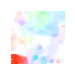

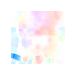

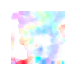

In [142]:
optical_flow(r'E:\JupyterWorkspace\opticalflow\train_data\fake\aapnvogymq.mp4',r"E:\JupyterWorkspace\opticalflow\save\fake\\",'aapnvogymq.mp4_') #test

# 数据保存

In [ ]:
path = ['E:/JupyterWorkspace/opticalflow/train_data/fake//', 'E:/JupyterWorkspace/opticalflow/train_data/real//']
#number of samples from each dataset
stop = 73
number_iter = 2 * stop
iter_1 = 0
iter_2 = 0

for z in range(2):
    iter_ = 0
    if z==0:
        path_list=os.listdir(path[0])
        for filename in path_list:
            if filename.endswith(('.mp4')):
                print(filename)
                optical_flow(path[0]+filename,r"E:\JupyterWorkspace\opticalflow\save\fake\\",filename)
                iter_1+=1
                print(iter_1)
                if iter_1 >= stop:
                    break

    if z==1:
        path_list=os.listdir(path[1])
        for filename in path_list:
            if filename.endswith(('.mp4')):
                print(filename)
                optical_flow(path[1]+filename,r"E:\JupyterWorkspace\opticalflow\save\real\\",filename)
                iter_2+=1
                print(iter_2)
                if iter_2 >= stop:
                    break

print("DATA Saved")    

aagfhgtpmv.mp4
[[[ 0.19215594 -0.10550465]
  [ 0.27959242 -0.15192977]
  [ 0.36071116 -0.18646605]
  ...
  [ 0.16987984 -0.10763942]
  [ 0.14434555 -0.08932115]
  [ 0.11938627 -0.06963646]]

 [[ 0.26565704 -0.15192038]
  [ 0.34366524 -0.20189013]
  [ 0.4050516  -0.2371461 ]
  ...
  [ 0.23283398 -0.1493265 ]
  [ 0.20552583 -0.12860142]
  [ 0.17769362 -0.10457414]]

 [[ 0.33457887 -0.197924  ]
  [ 0.41180956 -0.25278723]
  [ 0.46507767 -0.28961107]
  ...
  [ 0.30392468 -0.19491315]
  [ 0.27434    -0.1716596 ]
  [ 0.2417736  -0.14155963]]

 ...

 [[ 0.0914876  -0.0440174 ]
  [ 0.16641927 -0.080952  ]
  [ 0.27760902 -0.14465064]
  ...
  [ 0.42614877 -0.23338453]
  [ 0.43790904 -0.22445752]
  [ 0.42528763 -0.20212318]]

 [[ 0.06352641 -0.03126691]
  [ 0.10703269 -0.05382452]
  [ 0.18506242 -0.09473611]
  ...
  [ 0.39300135 -0.2040849 ]
  [ 0.40345696 -0.19431522]
  [ 0.3733087  -0.16434583]]

 [[ 0.04320743 -0.02109482]
  [ 0.06684747 -0.03492246]
  [ 0.11328366 -0.0591656 ]
  ...
  [ 0.352

  [-4.3479681e-01  1.0585436e+01]]]
[[[-0.612986    0.618641  ]
  [-1.1016551   1.289757  ]
  [-1.6560297   1.9854324 ]
  ...
  [ 0.7042162   0.90246004]
  [ 0.68484664  0.7842114 ]
  [ 0.588502    0.60811275]]

 [[-0.7073077   0.7499564 ]
  [-1.1970208   1.4740498 ]
  [-1.6909798   2.1712227 ]
  ...
  [ 0.69904923  1.3788925 ]
  [ 0.7044381   1.1787497 ]
  [ 0.6339173   0.88592553]]

 [[-0.83283377  0.8932659 ]
  [-1.3545884   1.646437  ]
  [-1.8035158   2.2990952 ]
  ...
  [ 1.0092857   2.328017  ]
  [ 1.0401362   2.1032958 ]
  [ 0.9460255   1.663955  ]]

 ...

 [[-0.14347292 -0.24974266]
  [-0.29542154 -0.5139399 ]
  [-0.43386835 -0.74134666]
  ...
  [-1.8862735  -1.0696257 ]
  [-1.6336963  -0.7393897 ]
  [-1.2779331  -0.63352245]]

 [[-0.10954999 -0.19810171]
  [-0.21432334 -0.38059655]
  [-0.30697393 -0.5310306 ]
  ...
  [-1.7502077  -0.85147613]
  [-1.4907137  -0.561174  ]
  [-1.142632   -0.47977668]]

 [[-0.068786   -0.13279451]
  [-0.12800655 -0.23783125]
  [-0.177767   -0.3194

  [-0.19928125  0.05319965]]]
[[[-1.6968491   1.0904121 ]
  [-1.688879    1.3284352 ]
  [-1.6578203   1.4584677 ]
  ...
  [-1.305127    2.7374806 ]
  [-0.7613194   2.6655643 ]
  [ 0.02006119  2.5410426 ]]

 [[-1.8667207   1.1421622 ]
  [-1.8092277   1.3587445 ]
  [-1.7527941   1.4825448 ]
  ...
  [-1.2279991   2.907804  ]
  [-0.6492917   2.9415815 ]
  [ 0.24694756  2.9647894 ]]

 [[-2.0681207   1.0955693 ]
  [-2.0974755   1.283208  ]
  [-2.0923727   1.38376   ]
  ...
  [-0.89523226  3.0346174 ]
  [-0.30882797  3.1308398 ]
  [ 0.5635679   3.228075  ]]

 ...

 [[-0.04411114  0.04470247]
  [-0.05282706  0.0526989 ]
  [-0.06040336  0.05994445]
  ...
  [ 0.07673444  0.04142252]
  [ 0.07308947  0.03457534]
  [ 0.06302502  0.02883674]]

 [[-0.02473714  0.02566106]
  [-0.03334487  0.03364584]
  [-0.03863009  0.0399295 ]
  ...
  [ 0.08259676  0.03212866]
  [ 0.07818846  0.02757317]
  [ 0.0681155   0.02393713]]

 [[-0.01310614  0.01283724]
  [-0.02002092  0.01981245]
  [-0.02265635  0.02409679]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[[[-6.0296679e+00  5.9833660e+00]
  [-6.6665244e+00  6.3089471e+00]
  [-6.9305511e+00  6.5025611e+00]
  ...
  [-8.2711589e-01  3.3498054e+00]
  [-8.1529063e-01  2.8506436e+00]
  [-1.0984004e+00  2.2182992e+00]]

 [[-5.6094656e+00  6.7676411e+00]
  [-6.5188317e+00  6.9856658e+00]
  [-6.9868274e+00  7.1372056e+00]
  ...
  [-8.2524878e-01  3.1683054e+00]
  [-7.9408026e-01  2.8284051e+00]
  [-1.1627444e+00  2.3872750e+00]]

 [[-6.2688131e+00  6.1254830e+00]
  [-7.0957427e+00  6.1622391e+00]
  [-7.6682935e+00  6.2337122e+00]
  ...
  [-8.8735187e-01  3.0729456e+00]
  [-8.0575860e-01  2.8240707e+00]
  [-1.1764913e+00  2.4921000e+00]]

 ...

 [[-2.6730141e-01 -1.2506793e-01]
  [-3.0440664e-01 -1.4481975e-01]
  [-3.3981329e-01 -1.6405809e-01]
  ...
  [-9.4045959e-02  3.9545130e-02]
  [-6.9865905e-02  2.8120462e-02]
  [-5.0796267e-02  1.9275846e-02]]

 [[-1.6308844e-01 -6.0859557e-02]
  [-1.9236524e-01 -6.9140717e-02]
  [-2.3209842e-01 -8.6710811e-02]
  ...
  [-5.0825734e-02  1.8722700e-02]
  [-

  [-1.2177581e-03 -2.5777796e-02]]]
[[[-9.34226608e+00 -1.05698967e+00]
  [-1.00929031e+01 -1.04431546e+00]
  [-1.06365223e+01 -1.01086175e+00]
  ...
  [-2.43517477e-02  4.05065774e-04]
  [-1.72055624e-02  9.64288018e-04]
  [-1.14665823e-02  1.35273940e-03]]

 [[-9.34737968e+00 -1.13298619e+00]
  [-9.95170116e+00 -1.15916717e+00]
  [-1.04280214e+01 -1.15731776e+00]
  ...
  [-3.38413604e-02  5.48370648e-04]
  [-2.48816516e-02  1.27762207e-03]
  [-1.75120234e-02  1.86099508e-03]]

 [[-9.40628052e+00 -1.07942247e+00]
  [-9.92422390e+00 -1.08456457e+00]
  [-1.03534822e+01 -1.07253814e+00]
  ...
  [-8.05340260e-02  1.45019882e-03]
  [-5.94493411e-02  2.65182951e-03]
  [-4.09585126e-02  3.37160751e-03]]

 ...

 [[-1.31017238e-01  8.00826028e-02]
  [-2.30738759e-01  1.45065159e-01]
  [-3.14234495e-01  2.10120320e-01]
  ...
  [ 3.03155575e-02  3.41658406e-02]
  [ 2.57064048e-02  3.13294604e-02]
  [ 1.88797303e-02  2.70002559e-02]]

 [[-1.02803968e-01  6.16564937e-02]
  [-1.88328385e-01  1.1697

  [ 5.53623447e-03 -2.21495589e-04]]]
[[[-3.9277742e+00 -1.3849752e+00]
  [-4.0917797e+00 -1.5113592e+00]
  [-4.5477557e+00 -1.6653399e+00]
  ...
  [-3.4200724e-02 -2.4663391e-02]
  [-2.8214864e-02 -2.1835862e-02]
  [-2.1113100e-02 -1.8818436e-02]]

 [[-4.1729951e+00 -1.6536267e+00]
  [-4.4486127e+00 -1.7373493e+00]
  [-5.0114422e+00 -1.8690044e+00]
  ...
  [-7.2862282e-02 -4.5006931e-02]
  [-6.3017339e-02 -3.9460283e-02]
  [-5.0528351e-02 -3.2885648e-02]]

 [[-4.4075823e+00 -2.0557058e+00]
  [-4.6460009e+00 -2.0956445e+00]
  [-5.1531801e+00 -2.1776960e+00]
  ...
  [-1.1504889e-01 -6.1655682e-02]
  [-1.0059728e-01 -5.3574037e-02]
  [-8.1274666e-02 -4.3262538e-02]]

 ...

 [[ 6.8568200e-02 -1.6823500e-01]
  [ 8.4184848e-02 -2.2506803e-01]
  [ 7.8419372e-02 -2.7114770e-01]
  ...
  [ 7.2779716e-03 -7.8922799e-03]
  [ 4.4166143e-03 -4.8678792e-03]
  [ 3.0328126e-03 -3.3935362e-03]]

 [[ 3.4898255e-02 -9.4471037e-02]
  [ 3.6134526e-02 -1.2123614e-01]
  [ 2.7757807e-02 -1.5639170e-01]
  ...


  [-7.14561465e-05  2.29174184e-05]]]
[[[ 1.0814372e+00  4.0636671e-01]
  [ 1.1028014e+00  4.0820009e-01]
  [ 1.1900131e+00  4.3402684e-01]
  ...
  [ 1.0920322e-02  8.1605127e-04]
  [ 7.5341878e-03  6.1844848e-04]
  [ 4.0625143e-03  3.2405060e-04]]

 [[ 1.3381288e+00  5.0349712e-01]
  [ 1.3524085e+00  4.9038824e-01]
  [ 1.3764349e+00  4.8869124e-01]
  ...
  [ 1.8558664e-02  1.3843676e-03]
  [ 1.2423581e-02  9.9864521e-04]
  [ 6.3716429e-03  5.0123612e-04]]

 [[ 1.5599202e+00  6.4637369e-01]
  [ 1.5464085e+00  6.1178797e-01]
  [ 1.5048870e+00  5.7831717e-01]
  ...
  [ 2.7269373e-02  2.7393701e-03]
  [ 1.8655991e-02  1.9806395e-03]
  [ 1.0290035e-02  1.0395109e-03]]

 ...

 [[ 4.2371023e-01  9.1639942e-01]
  [ 7.1412283e-01  1.7345408e+00]
  [ 8.7385046e-01  2.5864191e+00]
  ...
  [-7.9209734e-05  5.1472429e-04]
  [-5.3735388e-05  3.3783086e-04]
  [-2.3178402e-05  1.7249068e-04]]

 [[ 4.4020522e-01  9.1628999e-01]
  [ 7.3946559e-01  1.7438185e+00]
  [ 8.9529932e-01  2.5968001e+00]
  ...


  [-5.09609090e-05 -2.72185048e-06]]]
[[[ 6.79887819e+00  1.39727056e+00]
  [ 7.03274393e+00  1.37110841e+00]
  [ 7.01996565e+00  1.31216240e+00]
  ...
  [ 4.17821437e-01  1.54225200e-01]
  [ 2.59860277e-01  9.59640443e-02]
  [ 1.35888711e-01  5.12939282e-02]]

 [[ 7.06289387e+00  1.47439194e+00]
  [ 7.19599581e+00  1.42884386e+00]
  [ 7.12809658e+00  1.35785770e+00]
  ...
  [ 4.46227610e-01  1.64056748e-01]
  [ 2.78844833e-01  1.01893485e-01]
  [ 1.46094248e-01  5.39787859e-02]]

 [[ 7.08232927e+00  1.30378914e+00]
  [ 7.10259104e+00  1.25215399e+00]
  [ 6.99666119e+00  1.19840288e+00]
  ...
  [ 4.62403804e-01  1.68402910e-01]
  [ 2.91655868e-01  1.05540201e-01]
  [ 1.54154927e-01  5.61381504e-02]]

 ...

 [[-4.22825515e-02  1.31193474e-01]
  [-1.86252326e-01  1.71298176e-01]
  [-3.19271296e-01  2.16594577e-01]
  ...
  [-1.46049744e-04  9.06574132e-06]
  [-1.09630069e-04  2.26686116e-05]
  [-9.59101453e-05  4.24575592e-05]]

 [[-8.91776755e-02  9.32164937e-02]
  [-2.45169356e-01  1.20

  [-9.82450911e-06 -1.21727953e-06]]]
[[[ 1.31983447e+00  1.54964738e-02]
  [ 2.35998559e+00  5.74287772e-02]
  [ 3.15612769e+00  7.45370910e-02]
  ...
  [ 1.50333241e-01  4.41230163e-02]
  [ 1.21150091e-01  3.40936892e-02]
  [ 8.39343891e-02  2.16662679e-02]]

 [[ 2.30355096e+00  4.24959846e-02]
  [ 3.83225894e+00  9.65782553e-02]
  [ 4.91534948e+00  1.17165700e-01]
  ...
  [ 5.87578356e-01  1.77181989e-01]
  [ 4.76018310e-01  1.35075927e-01]
  [ 3.43842924e-01  8.78625214e-02]]

 [[ 4.19464922e+00  1.67925790e-01]
  [ 6.00059748e+00  2.44702742e-01]
  [ 7.19693899e+00  2.78369129e-01]
  ...
  [ 9.53493714e-01  2.45718032e-01]
  [ 7.92917609e-01  1.90472513e-01]
  [ 6.00263834e-01  1.28538534e-01]]

 ...

 [[-7.95209259e-02  4.86177579e-02]
  [-1.00899585e-01  6.30438030e-02]
  [-1.08538814e-01  7.53920451e-02]
  ...
  [ 1.25593677e-01  4.84730601e-02]
  [ 4.32621390e-02  1.75214857e-02]
  [ 1.28329601e-02  4.91371704e-03]]

 [[-8.11590999e-02  2.75326036e-02]
  [-1.00027159e-01  3.88

  [-1.15021920e+00  1.37640014e-01]]]
[[[-1.15255199e-04 -1.16951334e-04]
  [-1.49508734e-04 -1.66135520e-04]
  [-1.59740550e-04 -2.36185282e-04]
  ...
  [-5.48903234e-02  1.18571132e-01]
  [-1.72268823e-02  3.78317572e-02]
  [-6.29032962e-03  1.38607305e-02]]

 [[-2.50698242e-04 -2.42450682e-04]
  [-3.38177691e-04 -3.33772885e-04]
  [-3.52515170e-04 -4.51937056e-04]
  ...
  [-7.76986256e-02  1.68886557e-01]
  [-2.13849507e-02  4.70401496e-02]
  [-8.56910180e-03  1.89045854e-02]]

 [[-5.04190626e-04 -5.25116106e-04]
  [-7.17586605e-04 -7.77065521e-04]
  [-6.64076360e-04 -1.24038558e-03]
  ...
  [-1.45036981e-01  3.20535839e-01]
  [-2.61358358e-02  5.78149147e-02]
  [-1.01153497e-02  2.23684087e-02]]

 ...

 [[ 1.72350657e+00  1.29197568e-01]
  [ 1.78159523e+00  2.59306759e-01]
  [ 1.30639470e+00  1.62237972e-01]
  ...
  [-3.46918137e-06 -6.36633615e-07]
  [-1.04329536e-06  9.42510894e-07]
  [ 1.08474308e-06  2.19046115e-06]]

 [[ 1.73273242e+00  1.40978202e-01]
  [ 1.80431533e+00  2.75

  [ 1.1665718e-06  5.9715433e-08]]]
[[[ 2.5690522e-05  1.3910635e-05]
  [ 9.8001101e-06  6.7667599e-05]
  [-1.1608370e-05  3.1528441e-04]
  ...
  [ 3.6649336e-03  4.1890680e-03]
  [ 8.6681999e-04  9.4406895e-04]
  [ 2.8898209e-04  3.3183265e-04]]

 [[-9.2010378e-05  6.5634893e-05]
  [-4.8945216e-04  2.8966551e-04]
  [-1.1946212e-03  1.1413083e-03]
  ...
  [ 1.6282763e-02  1.8933319e-02]
  [ 2.3263919e-03  2.5230430e-03]
  [ 5.3996727e-04  6.1461277e-04]]

 [[-3.7646983e-04  1.7041827e-04]
  [-1.7300361e-03  8.0867088e-04]
  [-4.1380702e-03  2.8848995e-03]
  ...
  [ 9.8264113e-02  1.1309014e-01]
  [ 1.2507517e-02  1.3217899e-02]
  [ 1.9813639e-03  2.1474147e-03]]

 ...

 [[ 1.3109055e+00 -3.4130000e-02]
  [ 1.4392339e+00 -1.7180052e-02]
  [ 1.5278174e+00 -4.1817972e-03]
  ...
  [ 1.0427861e-04  2.3301733e-05]
  [ 4.8704147e-05  1.7772829e-05]
  [ 2.3495566e-05  8.0386135e-06]]

 [[ 1.2871315e+00 -3.6590010e-02]
  [ 1.4171576e+00 -2.1029862e-02]
  [ 1.5093946e+00 -8.3079245e-03]
  ...
  

  [ 1.9187593e-05 -4.3578771e-06]]]
[[[-8.09087232e-02 -1.14044599e-01]
  [-1.65481463e-01 -2.45256513e-01]
  [-3.57195079e-01 -4.88971174e-01]
  ...
  [ 1.42295503e-05 -4.80280942e-05]
  [ 7.09897586e-06 -2.65079616e-05]
  [ 2.28452336e-06 -9.50450976e-06]]

 [[-9.60822552e-02 -1.38093203e-01]
  [-1.97243094e-01 -2.89864153e-01]
  [-4.76686299e-01 -6.08057797e-01]
  ...
  [ 2.63483744e-05 -9.70248948e-05]
  [ 1.44162032e-05 -6.09959643e-05]
  [ 5.59344971e-06 -2.64915143e-05]]

 [[-1.15091376e-01 -1.68582857e-01]
  [-2.32786432e-01 -3.42688203e-01]
  [-5.62640309e-01 -7.10380137e-01]
  ...
  [ 4.09924796e-05 -1.74206391e-04]
  [ 2.47182506e-05 -1.19085387e-04]
  [ 1.30208928e-05 -5.79267980e-05]]

 ...

 [[-1.48679695e+01  4.22805834e+00]
  [-1.58406191e+01  3.90484118e+00]
  [-1.69433441e+01  3.52761889e+00]
  ...
  [-1.73225326e-05 -1.33846333e-05]
  [-1.32889745e-05 -1.31882816e-05]
  [-9.28842655e-06 -1.23449117e-05]]

 [[-1.39674187e+01  4.78151083e+00]
  [-1.50133696e+01  4.4411